# Canny Edge Detector

The Canny edge detector is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images. It was developed by John F. Canny in 1986. Canny also produced a computational theory of edge detection explaining why the technique works [source](https://en.wikipedia.org/wiki/Canny_edge_detector)

In [1]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import convolve
from scipy import ndimage

#### Helper Functions

In [2]:
def read_image(path):
    """read image, given the file path"""
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

def rgb2gray(rgb):
    """cast image to gray scale"""
    return np.dot(rgb[...,:3], [0.2989, 0.5870,0.1140])

In [3]:
def gaussian_kernel(size, sigma=1):
    """1. Generate a Gaussian Kernel"""
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g


def sobel_filters(img):
    """2. Gradient Calculation on the image"""
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)


def non_max_suppression(img, D):
    """3. Apply Non-maximum suppression to image"""
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z


def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    """4. Double threshold"""
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)


def hysteresis(img, weak, strong=255):
    """5. Edge Tracking by Hysteresis"""
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img


def canny_detector(path):
    """Pipeline to generate edges from an image path"""
    
    img = rgb2gray(read_image(path))
    img_filtered = convolve(img, gaussian_kernel(10, sigma=1.4))
    grad, theta = sobel_filters(img_filtered)
    img_nms = non_max_suppression(grad, theta)
    img_thresh, weak, strong = threshold(img_nms, lowThresholdRatio=0.07, highThresholdRatio=0.19)
    img_edge = hysteresis(img_thresh, weak, strong=strong)
    img_final = invert(img_edge)
    return img_final


def invert(image):
    """invert image"""
    image = abs(image - 255)
    return image

### Sample Output

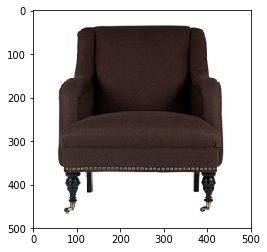

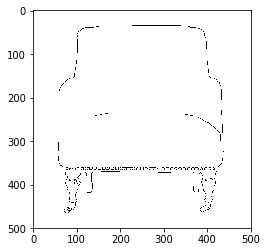

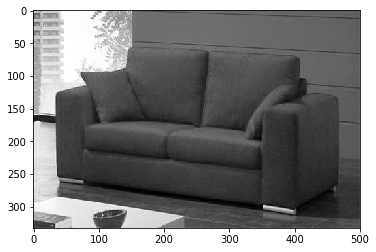

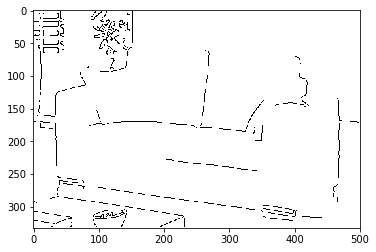

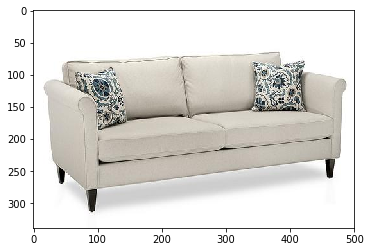

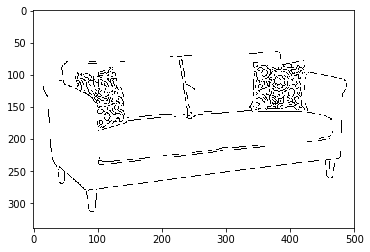

In [5]:
PATH = Path("img/sofa")
f = PATH.iterdir()

for i in range(3):
    path = next(f)
    plt.imshow(read_image(path), cmap='gray')
    plt.show()
    plt.imshow(canny_detector(path), cmap='gray')
    plt.show()

### Generate Sketches

In [24]:
sketch_path = Path('img/sketch')
sketch_path.mkdir(exist_ok=True)

for path in PATH.iterdir():
    sketch = canny_detector(path)
    fname = path.parts[-1]
    cv2.imwrite(str(sketch_path/fname), sketch)

### Source:
Algorithm & code from this [article](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123)